### Case Study number of blogposts

See: 
http://archive.ics.uci.edu/ml/datasets/BlogFeedback

As suggested in the [paper](http://www.cs.bme.hu/~buza/pdfs/gfkl2012_blogs.pdf) and acomaning [talk](http://archive.ics.uci.edu/ml/datasets/BlogFeedback), we use only the base features

#### Results Hits@10 mean and stdderr


##### 20,5 with only base features
LR   5.483   0.181799  #<--- In the paper they had 5.450 +- 1.322 (whatever +- is)

Poisson 5.966 0.1763

ZI Poisson 6.0 0.15

In [1]:
import os
if not os.path.isfile('blogdata/BlogFeedback.zip'):
    !mkdir blogdata
    print("Installing wget")
    !pip install wget
    import wget
    print("Downloading file")
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip', 'blogdata/BlogFeedback.zip')
    print("Unzipping content")
    !unzip blogdata/BlogFeedback.zip -d blogdata
else:
    print("File exists")

File exists


In [2]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)


TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [4]:
USE_BASE = True #Use only the Basic features (successfully in paper)


In [5]:
# Loading to the data
d = np.loadtxt("blogdata/blogData_train.csv", delimiter=',', dtype=np.float32)
if USE_BASE:
  Xu = d[:,0:63]
else:
  Xu = d[:,0:279]

y = d[:,280]
d.shape, Xu.shape, y.shape



((52397, 281), (52397, 63), (52397,))

In [6]:
Xmean = np.mean(Xu,axis=0)
Xsd = np.std(Xu,axis=0)
X = (Xu-Xmean)/(Xsd+1e-10)
X = np.clip(X,-5,5)
np.max(X),np.min(X)



(5.0, -5.0)

In [7]:
def check_performance(model_mean):
  files = [f for f in os.listdir('blogdata/') if f.startswith('blogData_test')]
  hits_at10 = np.zeros(len(files))
  for i,f in enumerate(files):
      d = np.loadtxt("blogdata/"+f, delimiter=',', dtype=np.float32)
      #print("{}".format(i))
      Xtu = d[:,0:X.shape[1]]
      yt = d[:,280]
      Xt = (Xtu-Xmean) / (Xsd+1e-10)
      d.shape, Xtu.shape, yt.shape
      y_pred = model_mean.predict(Xt).flatten()
      idx_true = np.argsort(yt)[-10:]
      idx_pred = np.argsort(y_pred)[-10:] #The 10 higest
      hits_at10[i]=len(np.intersect1d(idx_true, idx_pred))
  return (np.mean(hits_at10), np.std(hits_at10)/np.sqrt(len(files)))


### Definition of a base model 

In [8]:
## Definition of the base model
from tensorflow.keras.regularizers import l2
def make_base(inputs):
    rate = tf.keras.layers.Dense(20,  kernel_regularizer=l2(1e-2),  bias_regularizer=l2(1e-4),activation='sigmoid')(inputs)
    return tf.keras.layers.Dense(5,  kernel_regularizer=l2(1e-2),  bias_regularizer=l2(1e-4),activation='sigmoid')(rate)

epochs = 30


### Fitting Normal

In [9]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
out = tf.keras.layers.Dense(1)(make_base(inputs))
model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
hist = model.fit(X, y, epochs=epochs, verbose=1, validation_split=0.1);

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 37us/sample - loss: 1571.3136 - val_loss: 236.2781
Epoch 2/30
47157/47157 [==============================] - 2s 33us/sample - loss: 1530.0945 - val_loss: 231.7477
Epoch 3/30
47157/47157 [==============================] - 2s 33us/sample - loss: 1496.4708 - val_loss: 226.7006
Epoch 4/30
47157/47157 [==============================] - 2s 32us/sample - loss: 1467.8049 - val_loss: 223.7113
Epoch 5/30
47157/47157 [==============================] - 2s 33us/sample - loss: 1443.6617 - val_loss: 221.6954
Epoch 6/30
47157/47157 [==============================] - 2s 32us/sample - loss: 1422.4355 - val_loss: 219.0939
Epoch 7/30
47157/47157 [==============================] - 2s 35us/sample - loss: 1403.7238 - val_loss: 216.9653
Epoch 8/30
47157/47157 [==============================] - 2s 35us/sample - loss: 1386.8299 - val_loss: 216.4647
Epoch 9/30
47157/47157 [==============================]

,hits@10 [mean],hits@10 [std]
normal,5.866667,0.157174


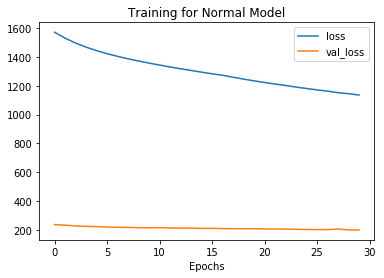

In [10]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Normal Model')
np.mean(hist.history['loss'])

d = check_performance(model)
import pandas as pd
df = pd.DataFrame({'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1]},index=['normal'])
df

### Fitting a poisson

In [11]:
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

In [12]:
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
rate = tf.keras.layers.Dense(1, 
                                 activation=tf.exp, 
                                 bias_initializer='zeros', 
                                 kernel_initializer='zeros')(make_base(inputs))

p_y = tfp.layers.DistributionLambda(tfd.Poisson)(rate) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

In [13]:
hist = model.fit(X, y, epochs=epochs, verbose=1, validation_split=0.1);

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 40us/sample - loss: 16.3863 - val_loss: 5.0832
Epoch 2/30
47157/47157 [==============================] - 2s 36us/sample - loss: 9.1366 - val_loss: 4.7522
Epoch 3/30
47157/47157 [==============================] - 2s 35us/sample - loss: 8.0396 - val_loss: 4.5491
Epoch 4/30
47157/47157 [==============================] - 2s 35us/sample - loss: 7.6609 - val_loss: 4.3988
Epoch 5/30
47157/47157 [==============================] - 2s 35us/sample - loss: 7.4592 - val_loss: 4.2827
Epoch 6/30
47157/47157 [==============================] - 2s 33us/sample - loss: 7.3126 - val_loss: 4.2124
Epoch 7/30
47157/47157 [==============================] - 2s 37us/sample - loss: 7.1924 - val_loss: 4.1656
Epoch 8/30
47157/47157 [==============================] - 2s 35us/sample - loss: 7.0852 - val_loss: 4.1360
Epoch 9/30
47157/47157 [==============================] - 2s 34us/sample - loss: 7.0019 - val_

,hits@10 [mean],hits@10 [std]
normal,5.866667,0.157174
Poisson,5.800000,0.180739


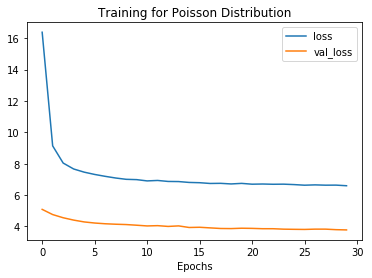

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Poisson Distribution')
np.mean(hist.history['loss'])

d = check_performance(model_mean)
df = df.append(pd.DataFrame({'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1]},index=['Poisson']))
df

### Fitting ZIP

In [15]:
def zero_inf(out): 
    rate = tf.math.exp(out[:,0]) #A 
    #rate = tf.math.softplus(out[:,0]) #A 
    s = tf.math.sigmoid(out[:,1:]) #B  
    probs = tf.concat([s, 1-s], axis=1) #C 
    print(np.min(rate), " ", np.max(rate), " ", np.min(s), np.max(s),"  ",np.min(out[:,1:]), np.max(out[:,1:]))
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#D
          components=[
            tfd.Deterministic(loc=tf.zeros_like(rate)), #E
            tfd.Poisson(rate=rate), #F 
        ])

In [16]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))

In [17]:
#   One pah for all
# from tensorflow.keras.regularizers import l2
# inputs = tf.keras.layers.Input(shape=(X.shape[1],))
# rate = tf.keras.layers.Dense(2,  kernel_regularizer=l2(0.01))(make_base(inputs))

# p_y = tfp.layers.DistributionLambda(zero_inf)(rate) 
# model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
# model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
# model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
# model.summary()

In [18]:
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
mean = tf.keras.layers.Dense(1,  kernel_regularizer=l2(0.01))(make_base(inputs))
z = tf.keras.layers.Dense(1,  kernel_regularizer=l2(0.01))(make_base(inputs))
tt = tf.concat([mean, z], axis=1)
p_y = tfp.layers.DistributionLambda(zero_inf)(tt) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
model.summary()

W0616 12:49:21.182576 140144165918464 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Exp:0", shape=(None,), dtype=float32)   Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/Sigmoid:0", shape=(None, 1), dtype=float32)    Tensor("distribution_lambda_1/strided_slice_2:0", shape=(None, 1), dtype=float32) Tensor("distribution_lambda_1/strided_slice_3:0", shape=(None, 1), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 63)]         0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 20)           1280        input_3[0][0]                    
_________________________________

In [19]:
hist = model.fit(X, y, epochs=epochs, verbose=1, validation_split=0.1);

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 2s 52us/sample - loss: 16.7776 - val_loss: 3.1990
Epoch 2/30
47157/47157 [==============================] - 2s 46us/sample - loss: 8.6297 - val_loss: 2.8389
Epoch 3/30
47157/47157 [==============================] - 2s 46us/sample - loss: 6.8041 - val_loss: 2.7794
Epoch 4/30
47157/47157 [==============================] - 2s 46us/sample - loss: 6.4357 - val_loss: 2.7722
Epoch 5/30
47157/47157 [==============================] - 2s 47us/sample - loss: 6.3063 - val_loss: 2.7451
Epoch 6/30
47157/47157 [==============================] - 2s 46us/sample - loss: 6.2321 - val_loss: 2.7345
Epoch 7/30
47157/47157 [==============================] - 2s 46us/sample - loss: 6.1666 - val_loss: 2.7353
Epoch 8/30
47157/47157 [==============================] - 2s 46us/sample - loss: 6.0986 - val_loss: 2.8335
Epoch 9/30
47157/47157 [==============================] - 2s 47us/sample - loss: 6.0562 - val_

,hits@10 [mean],hits@10 [std]
normal,5.866667,0.157174
Poisson,5.800000,0.180739
ZIP,5.633333,0.177899


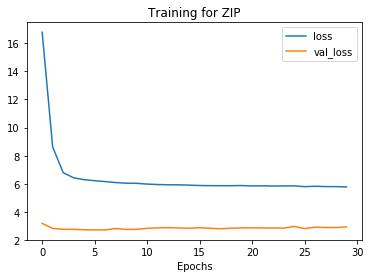

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for ZIP')
np.mean(hist.history['loss'])

d = check_performance(model_mean)
df = df.append(pd.DataFrame({'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1]},index=['ZIP']))
df

### Definition of a Mixture Model

In [21]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
#See https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution
def mixture_logistic(out, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)

    discretized_logistic_dist=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5))
    
    #print("mix_logi ", np.min(logits), " ", np.max(logits), " ", np.min(scale), np.max(scale),"  ",np.min(loc), np.max(loc))
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

In [22]:
from tensorflow.keras.regularizers import l2
inputs = tf.keras.layers.Input(shape=(X.shape[1],))

loc1    = tf.keras.layers.Dense(3,  kernel_regularizer=l2(0.01))(make_base(inputs))
scales1 = tf.keras.layers.Dense(3,  kernel_regularizer=l2(0.01))(make_base(inputs))
logits  = tf.keras.layers.Dense(3,  kernel_regularizer=l2(0.01))(make_base(inputs))

tt = tf.concat([loc1, scales1, logits], axis=1)
p_y = tfp.layers.DistributionLambda(mixture_logistic)(tt) 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean()) #For evaluation we need the mean
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 63)]         0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 20)           1280        input_4[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 20)           1280        input_4[0][0]                    
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 20)           1280        input_4[0][0]                    
____________________________________________________________________________________________

In [23]:
hist = model.fit(X, y, epochs=epochs, verbose=1, validation_split=0.1);

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 3s 64us/sample - loss: 1.5945 - val_loss: -3.6160
Epoch 2/30
47157/47157 [==============================] - 2s 50us/sample - loss: -0.9471 - val_loss: -3.8019
Epoch 3/30
47157/47157 [==============================] - 2s 52us/sample - loss: -1.2058 - val_loss: -3.9714
Epoch 4/30
47157/47157 [==============================] - 2s 51us/sample - loss: -1.3360 - val_loss: -4.3577
Epoch 5/30
47157/47157 [==============================] - 2s 50us/sample - loss: -1.3913 - val_loss: -4.1330
Epoch 6/30
47157/47157 [==============================] - 2s 50us/sample - loss: -1.4596 - val_loss: -4.3353
Epoch 7/30
47157/47157 [==============================] - 2s 51us/sample - loss: -1.4557 - val_loss: -4.1020
Epoch 8/30
47157/47157 [==============================] - 2s 51us/sample - loss: 0.5856 - val_loss: -4.3305
Epoch 9/30
47157/47157 [==============================] - 2s 51us/sample - loss: 

,hits@10 [mean],hits@10 [std]
normal,5.866667,0.157174
Poisson,5.800000,0.180739
ZIP,5.633333,0.177899
Mixture Model,0.216667,0.071070


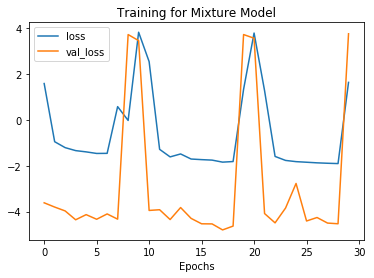

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('Epochs')
plt.title('Training for Mixture Model')
np.mean(hist.history['loss'])

d = check_performance(model_mean)
df = df.append(pd.DataFrame({'hits@10 [mean]' : d[0], 'hits@10 [std]' : d[1]},index=['Mixture Model']))
df